In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf 
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = Tokenizer(oov_token="<OOV>")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.options.display.max_colwidth = 120

In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### EDA

In [3]:
print("taille des datasets")
print(f" train : {data.shape}")
print(f" test : {test.shape}")

taille des datasets
 train : (7613, 5)
 test : (3263, 4)


In [4]:
print("Train set : pas de valeur Nan :")
print(data.isnull().sum())

print('')

print("Test set : pas de valeur Nan :")
print(test.isnull().sum())

Train set : pas de valeur Nan :
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test set : pas de valeur Nan :
id             0
keyword       26
location    1105
text           0
dtype: int64


In [5]:
print("Nombre de tweets Non Disaster -0- et Disaster -1- :")
data.target.value_counts()

Nombre de tweets Non Disaster -0- et Disaster -1- :


0    4342
1    3271
Name: target, dtype: int64

Non Disaster -0- et Disaster -1- :


/Users/berrehailmalika/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Nombre de tweets')

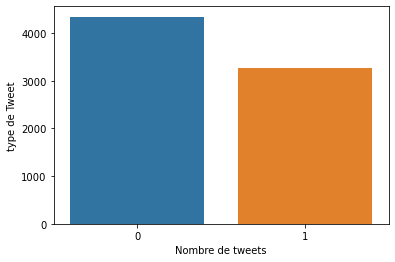

In [6]:
print('Non Disaster -0- et Disaster -1- :')

sns.countplot(data['target'])

plt.ylabel("type de Tweet")
plt.xlabel("Nombre de tweets")

In [7]:
print("les mots les plus utilisés :")
data.groupby('keyword').size().sort_values(ascending=False)

les mots les plus utilisés :


keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Length: 221, dtype: int64

In [8]:
data = data[['id','text','target']]
data.columns = ['id','text','target']

test = test[['id','text']]
test.columns = ['id','text']

### Data clean

In [9]:
nlp = spacy.load("en_core_web_sm")


In [10]:
# exemple twitt

twitts = data.sample(5)
for t in twitts.values:
    print(t)

[5522
 '70 years ago the first atomic attack flattened #Hiroshima 3 days later it was #Nagasaki both war crimes to put Moscow in its place'
 1]
[4881 'i swea it feels like im about to explode ??' 0]
[5267 'My biggest fear is disappointing the people who believe in me' 0]
[2507
 'Beat:G3 MOTOR VEHICLE COLLISION HIT AND RUN at RAINIER AV S / S CHARLES ST reported on 8/5/2015 6:08 PM Call# 15000270653'
 1]
[15 "I'm afraid that the tornado is coming to our area..." 1]


In [11]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = re.sub(r'[^\w\s]', ' ',tweet) 
    tweet = re.sub(r'[a-z]*[:.]+\S+', '', tweet) # Supprimez les virgules des nombres int
    tweet = " ".join(tweet.split())
    #tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = tweet.replace("û", "").replace("", "")
    tweet = tweet.replace(" +"," ").lower().strip() #lower text  
    return tweet

In [12]:
# isoler les nombre
def isolate_number(text):
    '''
    Mettez des espaces avant et après un nombre. => 236.00end devient 236.00 end
    '''
    clean_text = text
    #pattern (\d+[.]+\d*)([A-Za-z]+) identifes numbers attached to letters and separate them in groups.
    matches = re.findall('(\d+[.]+\d*)([A-Za-z]+)', text)
    for match in matches:
        unsplit_match= ''.join(match)
        new_text = ' '.join(match)
        clean_text = re.sub(unsplit_match, new_text, clean_text)
    return clean_text

In [13]:
data['text_clean'] = data['text'].apply(lambda x: isolate_number(x))
data['text_clean'] = data['text_clean'].apply(lambda x: cleaner(x))
data['text_clean'] = data['text_clean'].str.replace('û','')

test['text_clean'] = test['text'].apply(lambda x: isolate_number(x))

test['text_clean'] = test['text_clean'].apply(lambda x: cleaner(x))
test['text_clean'] = test['text_clean'].str.replace('û','')

In [14]:
data.head(2)

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada


In [15]:
# Lemmatisation : convertir un mot à sa forme racine.

def lemmatization(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

data['text_target'] = data['text_clean'].apply(lambda x: lemmatization(x))
test['text_target'] = test['text_clean'].apply(lambda x: lemmatization(x))

In [16]:
data.head(2)

,id,text,target,text_clean,text_target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,our deed be the reason of this earthquake may allah forgive we all
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada


### Visualisation data

In [17]:
def wordcloud(df, column, title):
    words = ' '.join(df[column].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords=stopwords, width=512, height=512).generate(words)
    plt.figure(figsize=(50,8), frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

Importance mots : Disasters Tweets



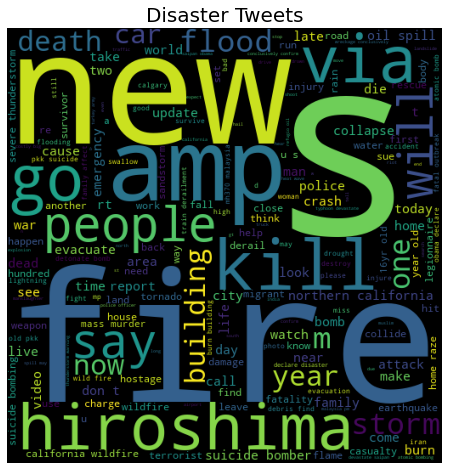

Importance mots : No Disasters Tweets



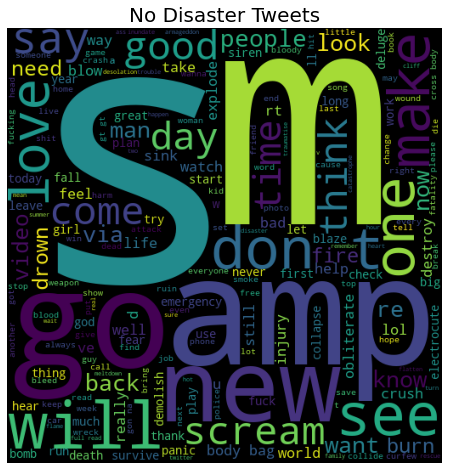

In [18]:
print("Importance mots : Disasters Tweets")
print('')
wordcloud(data[data["target"]==1], "text_target", "Disaster Tweets")

print("Importance mots : No Disasters Tweets")
print('')
wordcloud(data[data["target"]==0], "text_target", "No Disaster Tweets")

# amp : to make someone more energetic

In [19]:
#  matrice TF-IDF 

vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(data['text_clean'])
dense = X.toarray()

print("nombre de mots")
len(vectorizer.vocabulary_)

nombre de mots


14695

In [20]:
cv= CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data.text_clean)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

print("Les 10 mots les plus écrit")

words_freq[:10]

Les 10 mots les plus écrit


[('like', 348),
 ('amp', 344),
 ('just', 323),
 ('new', 226),
 ('people', 199),
 ('news', 197),
 ('don', 190),
 ('video', 166),
 ('disaster', 158),
 ('emergency', 158)]

Text(0.5, 1.0, 'Top 30 des mots les plus fréquents')

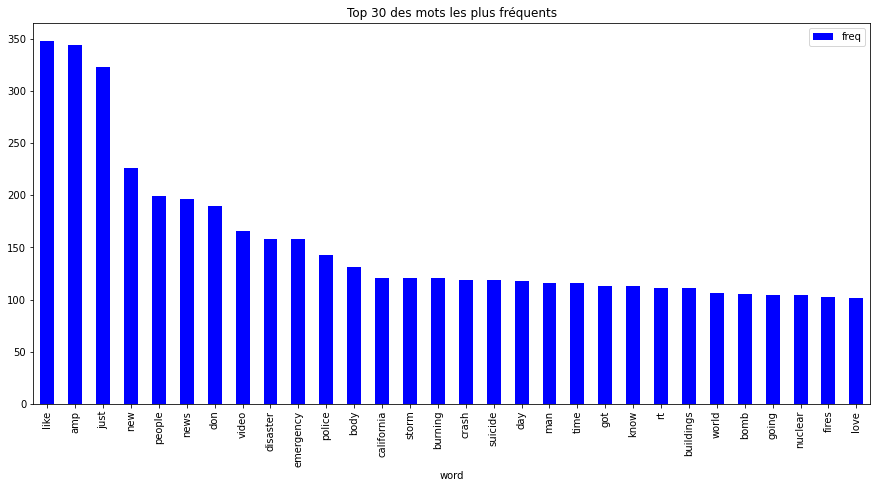

In [21]:

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Top 30 des mots les plus fréquents")

Text(0.5, 1.0, ' Vocabulaire des commentaires')

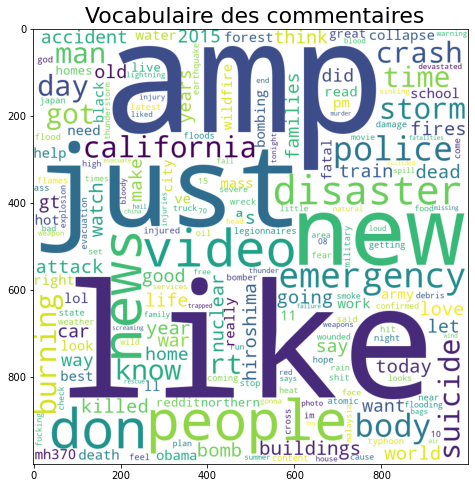

In [22]:
word_cloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(word_cloud)
plt.title(" Vocabulaire des commentaires", fontsize = 22)


### Data Preparation

In [23]:
tweets = data['text_target'] 
target = data['target']

vocab_size = 5000 

embedding_dim = 100

max_length = 100

trunc_type='post'

padding_type='post'

oov_tok = "<OOV>"

training_size = 20000

X_train, X_test, y_train, y_test = train_test_split(tweets, target, 
random_state=3, test_size=0.2)

In [24]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

text_index = tokenizer.word_index

data_sequences = tokenizer.texts_to_sequences(X_train)

data_padded = pad_sequences(data_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)

test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

tst_sequences = tokenizer.texts_to_sequences(test["text_clean"])

tst_padded = pad_sequences(tst_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_data = np.array(data_padded)

training_labels = np.array(y_train)

eval_data = np.array(test_padded)

eval_labels = np.array(y_test)

tst_data = tst_padded

tst_labels = np.array(test["id"])

### Data NLP Preprocessing & Model

In [25]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 502,449
Trainable params: 502,449
Non-trainable params: 0
_________________________________________________________________


In [27]:

#stopping which stop training when a monitored metric has stopped improving

stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lrr = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.5, min_lr=0.00001)

num_epochs = 15

history = model.fit(
    training_data, training_labels,
    epochs=num_epochs,
    batch_size = 32,
    validation_data=(eval_data, eval_labels), 
    verbose=2, callbacks=[stopping, lrr])

Epoch 1/15
191/191 - 2s - loss: 0.6767 - accuracy: 0.5739 - val_loss: 0.6697 - val_accuracy: 0.5522
Epoch 2/15
191/191 - 1s - loss: 0.5960 - accuracy: 0.6892 - val_loss: 0.5297 - val_accuracy: 0.7800
Epoch 3/15
191/191 - 1s - loss: 0.4442 - accuracy: 0.8230 - val_loss: 0.4987 - val_accuracy: 0.7708
Epoch 4/15
191/191 - 1s - loss: 0.3722 - accuracy: 0.8493 - val_loss: 0.4496 - val_accuracy: 0.8011
Epoch 5/15
191/191 - 1s - loss: 0.3229 - accuracy: 0.8675 - val_loss: 0.4508 - val_accuracy: 0.8043
Epoch 6/15
191/191 - 1s - loss: 0.2916 - accuracy: 0.8844 - val_loss: 0.4633 - val_accuracy: 0.8056
Epoch 7/15
191/191 - 1s - loss: 0.2658 - accuracy: 0.8926 - val_loss: 0.4727 - val_accuracy: 0.8063

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


<Figure size 432x288 with 0 Axes>

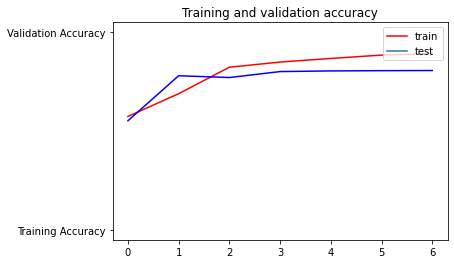

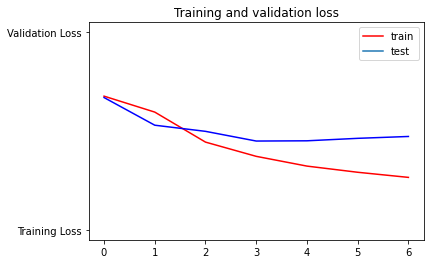

<Figure size 432x288 with 0 Axes>

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')

plt.title('Training and validation accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Training and validation loss')
plt.figure()

In [29]:
predictions = model.predict(tst_data)

predictions = np.around(predictions)

predictions = predictions.astype(int)

predictions_tweets = pd.DataFrame()

predictions_tweets["id"] = test["id"]

predictions_tweets["target"] = predictions

predictions_tweets['target'] = predictions_tweets['target'].replace([0,1],['Non Disaster','Disaster'])


In [30]:
predictions_tweets["target"].value_counts()

Non Disaster    2176
Disaster        1087
Name: target, dtype: int64

In [31]:
print("exemple de tweet 'Disaster' : ")

Disaster_id = predictions_tweets[predictions_tweets.target == "Disaster"].sample(1)

Disaster = test[test.id == int(Disaster_id.id)]

print("")

print(Disaster['text_target'].to_string(index=False))

exemple de tweet 'Disaster' : 

 special weather statement issue august 05 at 10 40pm edt by nws strong thunderstorm will impact portion


In [33]:
print("exemple de tweet 'Non Disaster' :")

No_Disaster_id = predictions_tweets[predictions_tweets.target == "Non Disaster"].sample(1)
NO_Disaster = test[test.id == int(No_Disaster_id.id)]
print("")

print(NO_Disaster['text_target'].to_string(index=False))


exemple de tweet 'Non Disaster' :

 no joke military man be the hot thing
